# Examining candidates

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import pyke
from pyke import KeplerTargetPixelFile
from glob import glob
import everest
import os
import fnmatch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from astropy.wcs import WCS
%matplotlib notebook


#%config InlineBackend.figure_format = 'retina'

/Users/ryanr/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
path = '/Users/ryanr/Documents/PhD/coding/Data/Kepler/' #
#path = '/Volumes/TOSHIBA EXT/K2/c5/*/*/'
#pixelfile = '../data/ktwo212535880-c06_lpd-targ.fits'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/c5/'

In [6]:
pixelfile = glob(path+'*200008645*.gz')[0]
#pixelfile = path + 'ktwo211322975-c05_lpd-targ.fits.gz'

hdu = fits.open(pixelfile)
dat = hdu[1].data
datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
time = dat["TIME"] + 2454833.0

# Finding the reference frame
n_steps = 12
std_vec = np.zeros(n_steps)
for i in range(n_steps):
    std_vec[i] = np.nanstd(datacube[i:-n_steps+i:n_steps,:,:] - datacube[i+n_steps*80,:,:])
Framemin = np.where(std_vec==np.nanmin(std_vec))[0][0]

# Remove all negative flux values, not physical
#datacube[datacube < 0] = 0

# Make a mask of the target object, using the reference frame 
Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
Mask[Mask>=1] = np.nan
Mask[Mask<1] = 1
# Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
Maskv2[Maskv2>=1] = np.nan
Maskv2[Maskv2<1] = 1
# Apply mask to data
Maskdata = datacube*Maskv2
#Maskdata[Maskdata < 0] = 0
#Maskdata = Maskdata[Framemin::12,:,:]
# Calculating the standard deviations of all frames, from which the significance of each
# frame's std can be compared.
stddist = np.zeros(Maskdata.shape[0])
for i in range(Maskdata.shape[0]):
    stddist[i] = np.nanstd(Maskdata[i,:,:])

/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater_equal
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in less
/Users/ryanr/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [24]:
# Section to calculate if any points are significant in a frame
from scipy.signal import convolve2d
kernel = np.ones((3,3))
temp = np.ma.masked_invalid(Maskv2)
Conv = convolve2d(temp.mask, kernel, mode="same")
MotionCotrol = Conv < 2

Stdframe = np.ones(Maskdata.shape)
framemask = np.ones(Maskdata.shape)

Index = []
for i in range(Stdframe.shape[0]+1):
    if i < Stdframe.shape[0]:
        framemask[:,:,:] = False
        if np.nanstd(Maskdata[i,:,:]) > np.nanmedian(stddist)+2*np.nanstd(stddist): # Conditioning on std for noise
            Stdframe[i,:,:] = Maskdata[i,:,:]/(np.nanmedian(Maskdata[i,:,:])+2*np.nanstd(Maskdata[i,:,:]))
            if Maskdata.shape[1]>1 and Maskdata.shape[2]>1:
                framemask[i,:,:] = Stdframe[i,:,:]*MotionCotrol <= 1
            else:
                framemask[i,:,:] = Stdframe[i,:,:]*(Conv<1) < 1
            if framemask[i].any():
                Index.append(i)
        else:
            framemask[i,:,:] = 0



def pix2coord(x,y):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

MaskIndex = []
Previous = []
AllMaskIndex = []
i = 0
while i < len(Index)-1:
    if Index[i+1]-Index[i] < 2:
        MaskIndex.append(i) 
    else: 
        MaskIndex = []
    if len(Previous) > 3 and len(MaskIndex) == 0:
        AllMaskIndex.append(Previous)
    Previous = MaskIndex
    i += 1
thingo = []
if len(AllMaskIndex) > 0:
    for i in range(len(AllMaskIndex)):
        TranMask = np.ones(Maskdata[Framemin].shape)

        for j in range(len(AllMaskIndex[i])):
            TranMask = convolve2d(TranMask, kernel, mode="same")*framemask[AllMaskIndex[i][j]] # Gives frames room for motion
        TranMask = convolve2d(TranMask, kernel, mode="same")
        if TranMask.any():
            # Generate a light curve from the transient masks
            LC = np.nansum(datacube*TranMask, axis = (1,2))
            #Find Coords of transient
            funny_keywords = {'1CTYP4': 'CTYPE1',
                  '2CTYP4': 'CTYPE2',
                  '1CRPX4': 'CRPIX1',
                  '2CRPX4': 'CRPIX2',
                  '1CRVL4': 'CRVAL1',
                  '2CRVL4': 'CRVAL2',
                  '1CUNI4': 'CUNIT1',
                  '2CUNI4': 'CUNIT2',
                  '1CDLT4': 'CDELT1',
                  '2CDLT4': 'CDELT2',
                  '11PC4': 'PC1_1',
                  '12PC4': 'PC1_2',
                  '21PC4': 'PC2_1',
                  '22PC4': 'PC2_2'}
            mywcs = {}
            for oldkey, newkey in funny_keywords.items():
                mywcs[newkey] = hdu[1].header[oldkey] 
            mywcs = WCS(mywcs)
            x, y = np.where(TranMask == 1)
            Coord = pix2coord(x[0],y[0])
            
            fig = plt.figure()
            # set up subplot grid
            gridspec.GridSpec(3,3)

            # large subplot
            plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
            plt.title('Masked light curve (JD '+str(time[AllMaskIndex[i][0]])+'RA '+str(Coord[0])+' DEC '+str(Coord[1]))
            plt.xlabel('Time (BJD)')
            plt.ylabel('Flux')
            plt.plot(time, LC,'.')
            plt.axvspan(time[AllMaskIndex[i][0]],time[AllMaskIndex[i][-1]], color = 'orange')
            plt.xlim(time[AllMaskIndex[i][0]]-5,time[AllMaskIndex[i][-1]]+5)


            # small subplot 1
            plt.subplot2grid((3,3), (0,2))
            plt.title('Reference')
            #plt.xlabel('Data values')
            #plt.ylabel('Frequency')
            plt.imshow(Maskdata[Framemin,:,:], origin='lower',vmax=200)

            # small subplot 2
            plt.subplot2grid((3,3), (1,2))

            plt.title('Mask')
            #plt.xlabel('Data values')
            #plt.ylabel('Frequency')
            plt.imshow(TranMask, origin='lower')

            # small subplot 3
            plt.subplot2grid((3,3), (2,2))
            plt.title('Event')
            #plt.xlabel('Data values')
            #plt.ylabel('Frequency')
            plt.imshow(Maskdata[AllMaskIndex[i][1],:,:], origin='lower',vmax=100)

            # fit subplots and save fig
            fig.tight_layout()
            #fig.set_size_inches(w=11,h=7)
            plt.savefig(save+pixelfile.split('/')[-1].split('-')[0]+' '+str(i)+'.pdf', bbox_inches = 'tight');
            Result = 'Possible'
            print('Possible')
            thingo.append(TranMask)
        else:
            Result = 'No'
else:
    Result = 'No'

/Users/ryanr/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater_equal


<IPython.core.display.Javascript object>


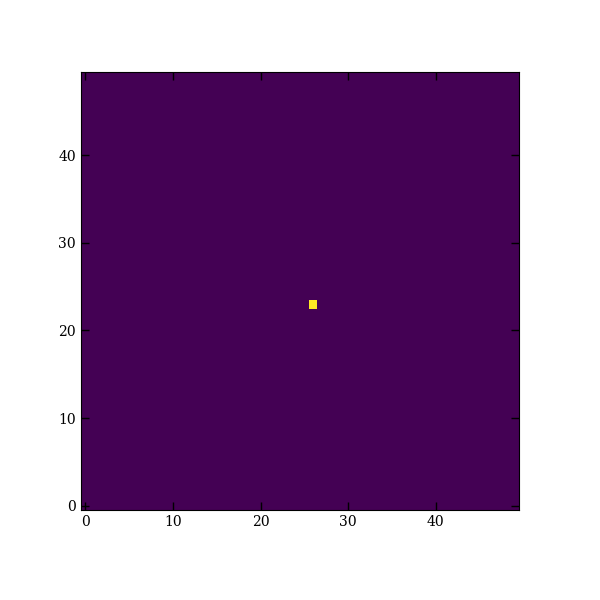

In [7]:
plt.figure()
plt.imshow(thingo[0],origin='lower')

<IPython.core.display.Javascript object>


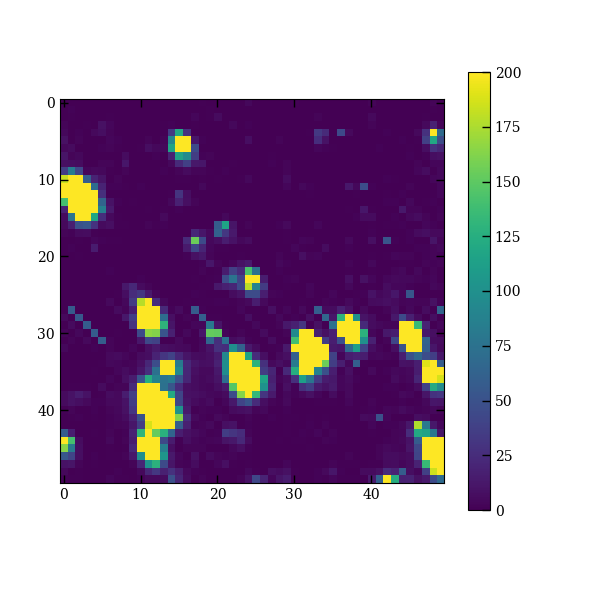

In [8]:
plt.figure()
plt.imshow(datacube[Framemin],vmax = 200)
plt.colorbar()

<IPython.core.display.Javascript object>


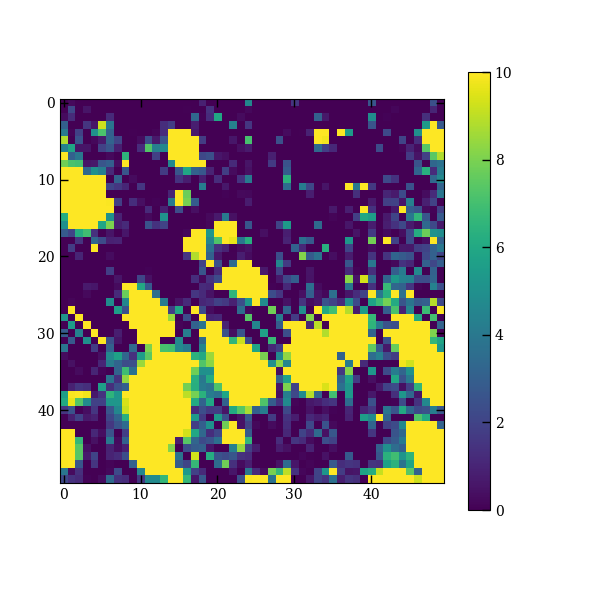

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [65]:
plt.figure()
plt.imshow(datacube[Framemin],vmax=10)
plt.colorbar()
plt.imshow(~thingo[0], alpha=.1, cmap='hot')

In [10]:
def pltdif(f):
    plt.plot(time[Framemin::12], np.nansum(Maskdata, axis=(1,2))[Framemin::12], '.', label='Sum ev. pixels', ms=4)
    plt.axvline(time[Framemin+f*12], color = 'k')
    plt.show()
    plt.imshow(Maskdata[Framemin+f*12, :,:],origin='lower')#,vmin=0,vmax=70)
    #plt.colorbar()
    plt.minorticks_on()
    plt.show()

<IPython.core.display.Javascript object>


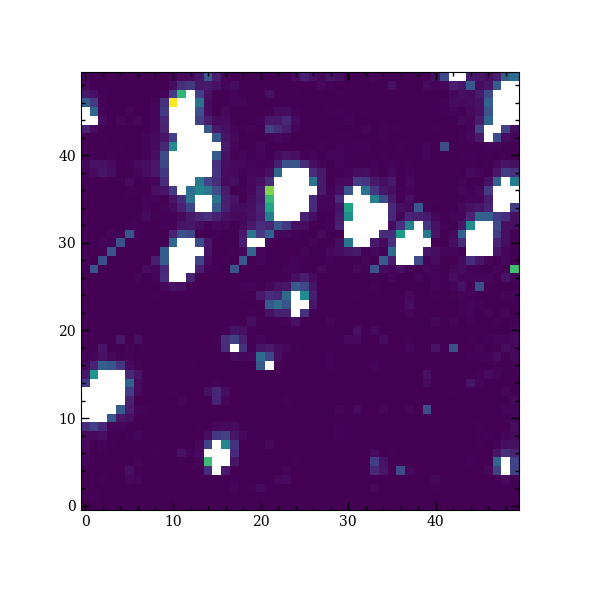

interactive(children=(IntSlider(value=160, description='f', max=321), Output()), _dom_classes=('widget-interact',))

In [11]:
plt.figure()
interact(pltdif, f=(0,321,1));

<IPython.core.display.Javascript object>


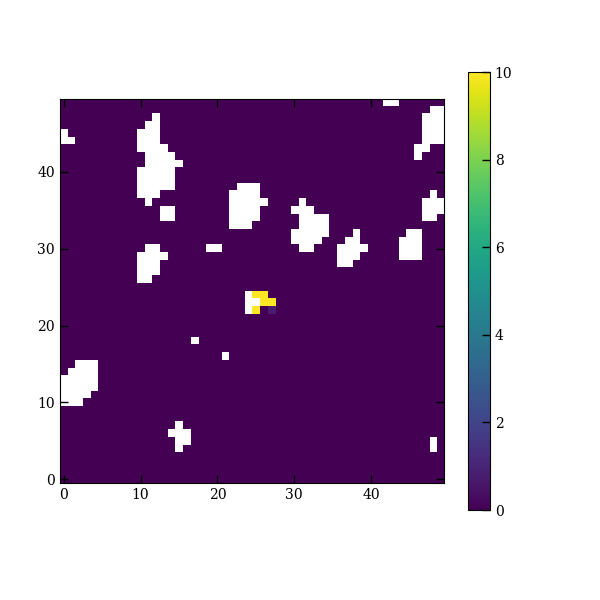

In [87]:
import matplotlib.animation as animation

fig = plt.figure()

thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = Maskdata[thingy,:,:]*thingo[0]
Maskdata2 = test#[Framemin::12]
im = plt.imshow(Maskdata2[Framemin,:,:], origin='lower', animated=True,vmax=10)
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, blit=True)
plt.colorbar()

In [13]:
test = datacube[Framemin] < 0

<IPython.core.display.Javascript object>


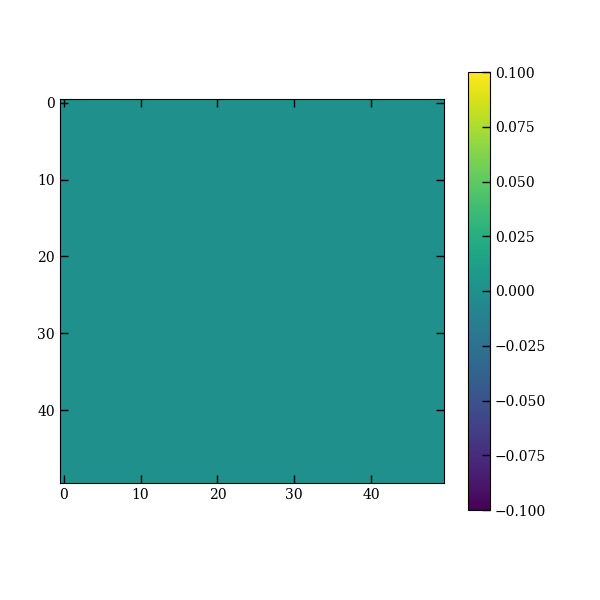

In [14]:
plt.figure()
plt.plot(np.nansum(Maskdata2,axis=(1,2)))

In [15]:
plt.imshow(np.nansum(test*datacube,axis=(0)),vmin = 0)
plt.colorbar()

In [16]:
thingo = np.nansum(Maskdata2,axis = (1,2)) != 0

In [17]:
thingo[thingo==False]

array([], dtype=bool)

In [18]:
thingo.shape

(3620,)

In [19]:
Maskdata.shape

(3663, 50, 50)

In [20]:
for i in range(Stdframe.shape[0]+1):
    if i < Stdframe.shape[0]:
        if np.nanstd(Maskdata[i,:,:]) > np.nanmedian(stddist)+2*np.nanstd(stddist): # Conditioning on std for noise
            Stdframe[i,:,:] = Maskdata[i,:,:]/(np.nanmedian(Maskdata[i,:,:])+np.nanstd(Maskdata[i,:,:]))
            
            framemask[i,:,:] = Stdframe[i,:,:] >= 1
            Index.append(i)
        else:
            framemask[i,:,:] = 0

/Users/ryanr/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal


/Users/ryanr/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


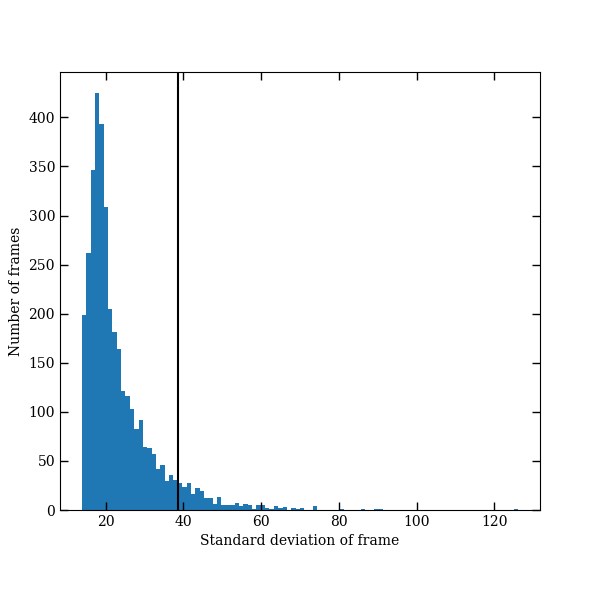

In [66]:
stddist = np.zeros(Maskdata.shape[0])
for i in range(Maskdata.shape[0]):
    stddist[i] = np.nanstd(Maskdata[i,:,:])
plt.figure()
plt.hist(stddist[~np.isnan(stddist)], bins = 'auto')
plt.axvline(np.nanmedian(stddist)+2*np.nanstd(stddist), color = 'k')
#plt.xlim(0,10)
plt.ylabel('Number of frames')
plt.xlabel('Standard deviation of frame');

In [24]:
np.where(framemask==1)

(array([ 182,  182,  182, ..., 3656, 3656, 3656]),
 array([ 3,  4,  4, ..., 49, 49, 49]),
 array([48, 16, 34, ..., 41, 48, 49]))

In [25]:
np.where(framemask[1916]==1)

(array([ 4,  5,  5,  7,  8, 14, 15, 15, 16, 16, 16, 17, 18, 19, 19, 20, 21,
        23, 23, 24, 25, 25, 27, 28, 28, 29, 29, 30, 30, 30, 30, 30, 31, 31,
        31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34,
        35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 38,
        38, 39, 39, 39, 39, 40, 41, 41, 42, 43, 44, 44, 44, 45, 45, 46, 46,
        46, 47, 47, 47, 48, 49, 49, 49]),
 array([47, 14, 47, 14, 15,  0,  0,  1,  1,  2,  3, 20, 16,  0, 16,  0,  0,
        21, 23, 23, 23, 24,  9,  9, 34,  9, 35, 10, 18, 30, 35, 43, 10, 11,
        18, 19, 35, 36, 43, 29, 36, 37, 43, 44, 21, 29, 30, 44, 45, 21, 30,
        12, 21, 29, 33, 46, 12, 13, 14, 20, 21, 30, 46,  9, 21, 46, 47,  9,
        22,  9, 22, 23, 24,  9,  9, 10, 10, 45,  9, 45, 46,  9, 46,  9, 10,
        46, 10, 11, 46, 47, 47, 48, 49]))

<IPython.core.display.Javascript object>


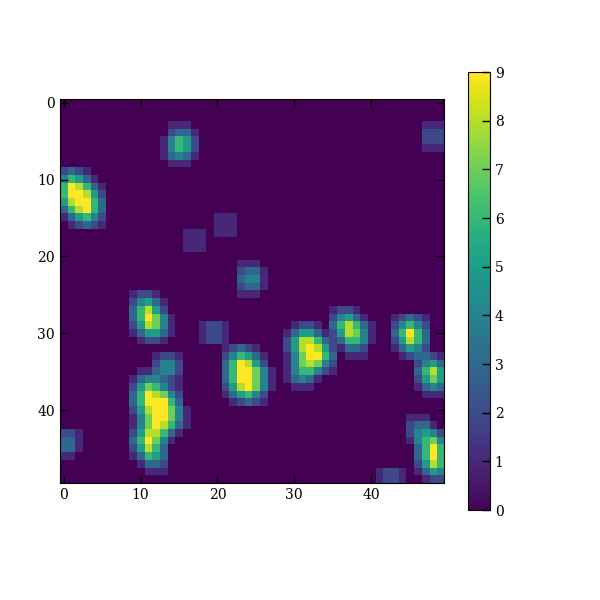

In [52]:
from scipy.signal import convolve2d
kernel = np.ones((3,3))
test = np.ma.masked_invalid(Maskv2)
Conv = convolve2d(test.mask, kernel, mode="same")
Elim = Conv < 2
plt.figure()
plt.imshow(Conv)
plt.colorbar()
plt.plot()

In [56]:
f = fits.open(pixelfile)
funny_keywords = {'1CTYP4': 'CTYPE1',
                  '2CTYP4': 'CTYPE2',
                  '1CRPX4': 'CRPIX1',
                  '2CRPX4': 'CRPIX2',
                  '1CRVL4': 'CRVAL1',
                  '2CRVL4': 'CRVAL2',
                  '1CUNI4': 'CUNIT1',
                  '2CUNI4': 'CUNIT2',
                  '1CDLT4': 'CDELT1',
                  '2CDLT4': 'CDELT2',
                  '11PC4': 'PC1_1',
                  '12PC4': 'PC1_2',
                  '21PC4': 'PC2_1',
                  '22PC4': 'PC2_2'}
mywcs = {}
for oldkey, newkey in funny_keywords.items():
    mywcs[newkey] = f[1].header[oldkey] 
print(WCS(mywcs).wcs_pix2world(1, 1, 1))
mywcs = WCS(mywcs)

[array(132.69067699020553), array(12.045990887440029)]


In [74]:
# Plot an image of a map with correct coordinates
def fitsplot(image,cmap = plt.cm.cubehelix,lims = (0,100),clabel='', ticklength=3, bad = 'w', proj=mywcs):
    #if ~isinstance(cmap, str):
    cmap.set_bad(bad,1.)
    fig = plt.figure()#figsize=fig_size)
    #fig.set_size_inches()#fig_width,fig_width) 
    ax = fig.add_subplot(111, projection=proj)
    im = ax.imshow(image,origin='lower',cmap=cmap,clim = lims)
    #plt.xlabel('GLON', fontsize=8)
    ra = ax.coords[0]
    ra.set_ticklabel(size=8)
    ra.set_axislabel(r'RA')
    ra.display_minor_ticks(True)
    dec = ax.coords[1]
    dec.set_ticklabel(size=8)
    dec.display_minor_ticks(True)
    #plt.tick_params(labelsize=20)
    dec.set_axislabel(r'DEC')
    c = plt.colorbar(im,fraction=0.046, pad=0.04)
    c.set_label(clabel)
    c.ax.tick_params(length=ticklength)
    plt.tight_layout()
    #ax = plt.gca()
    #divider = make_axes_locatable(ax)
    #width = axes_size.AxesY(ax, aspect=1./aspect)
    #pad = axes_size.Fraction(pad_fraction, width)
    #cax = divider.append_axes("right", size=width, pad=pad)
    #c = plt.colorbar(im, cax=cax)
    #c.set_label(clabel)
    ax = plt.gca()
    return fig, c

In [123]:
# For given pixel coordinates, get the world (Galactic) coordinates (l,b)
def pix2coord(x,y):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])
# For given world coordinates, get the pixel coordinates
def coord2pix(ra,dec):
    px, py = mywcs.wcs_world2pix(ra, dec, 0)
    return px, py

<IPython.core.display.Javascript object>


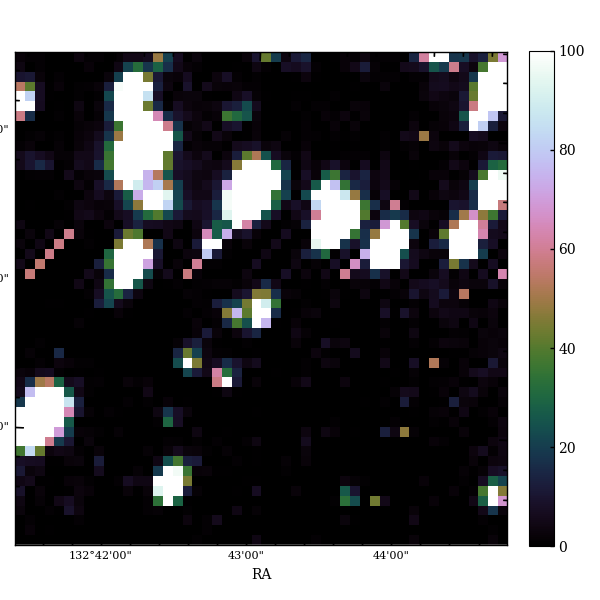

(<matplotlib.figure.Figure at 0x12def20b8>,
 <matplotlib.colorbar.Colorbar at 0x12df43b00>)

In [93]:
%matplotlib notebook
fig_size = (5,4)
fig_width = 4
fitsplot(datacube[Framemin],lims=(0,100))

In [86]:
# Plot an image of a map with correct coordinates
def fitsslice(data, chan, proj=mywcs,cmap='cubehelix',lims = (0,100), clabel = '', ticklength=3, figsize=(6,6)):
    fig = plt.figure()
    #fig.set_size_inches(figsize) 
    ax = plt.subplot(projection=proj, slices=('x', 'y', chan))
    im = ax.imshow(data, origin='lower',cmap=cmap, clim = lims)
    #plt.xlim(0,1440)
    #plt.ylim(0,721)
    ra = ax.coords[0]
    ra.set_ticklabel(size=8)
    ra.set_axislabel(r'RA')
    ra.display_minor_ticks(True)
    dec = ax.coords[1]
    dec.set_ticklabel(size=8)
    dec.display_minor_ticks(True)
    #plt.tick_params(labelsize=20)
    dec.set_axislabel(r'DEC')
    c = plt.colorbar(im,fraction=0.046, pad=0.04)
    c.set_label(clabel)
    c.ax.tick_params(length=ticklength)
    return fig,c

In [88]:
datacube.shape

(3663, 50, 50)

In [92]:
mywcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 132.71062574802761  12.00971865841222  
CRPIX : 19.54493057388936  33.351182719218343  
PC1_1 PC1_2  : -1.0003833653482901  0.027744564947107531  
PC2_1 PC2_2  : -0.027493956848350001  -0.99885426601498672  
CDELT : -0.0011050741315770001  0.001105074131576896  
NAXIS : 0  0

In [125]:
pix2coord(23,26)

array([ 132.71586025,   12.01659374])

In [124]:
wx, wy = mywcs.wcs_pix2world(23, 26, 0)

In [117]:
wx.shape

()

In [20]:
test = np.array([[1,0],[2,0]])

In [21]:
x, y = np.where(test == 2)

In [23]:

x[0]


1